In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [129]:
class ODE_Solver:

    def __init__(self, t_final, t_initial, G, L, n):

        # Parameters
        self.A = np.array([[0.5, 3.0], [3.0, 0.5]])
        self.B = np.array([[0.4, 5.0], [5.0, 0.4]])
        self.C = np.array([[0.3, 4.0], [4.0, 0.3]])
        self.D = np.array([[0.2, 1.0], [1.0, 0.2]])
        self.Q = np.array([[1.0, 2.0], [2.0, 1.0]])
        self.R = np.array([[1.0, 3.0], [3.0, 1.0]])
        self.S = np.array([[0.0, 3.0], [0.0, 2.0]])

        # Transpose of parameters
        self.A_T = np.transpose(self.A)
        self.B_T = np.transpose(self.B)
        self.C_T = np.transpose(self.C)
        self.D_T = np.transpose(self.D)
        self.S_T = np.transpose(self.S)

        # Compute the inverses Q_tilde, R_tilde, S_tilde
        self.QSSR = np.concatenate(
            (np.concatenate((self.Q, self.S.T), axis=1),
             np.concatenate((self.S, self.R), axis=1)),
            axis=0)
        self.QSSR_inv = np.linalg.inv(self.QSSR)
        self.Q_tilde = self.QSSR_inv[:2, :2]
        self.S_tilde = self.QSSR_inv[:2, 2:]
        self.R_tilde = self.QSSR_inv[2:, 2:]

        # Initial and final time interval
        self.t_final = t_final
        self.t_initial = t_initial

        # Number of steps
        self.n = n

        # Terminal conditions parameters
        self.G = G
        self.L = L

        # Dictionary to store the RHS of ODEs
        self.ode_functions = {
                    'P': self.P_RHS,
                    'P_tilde': self.P_tilde_RHS,
                    'M': self.M_RHS,
                    'M_tilde': self.M_tilde_RHS,
                    'N': self.N_RHS
        }

        # Dictionary to store the terminal conditions
        self.ode_terminal_conditions = {
            'P': -self.G,
            'P_tilde': -np.linalg.inv(self.G),
            'M': -self.L,
            'M_tilde': -np.linalg.inv(self.G) @ self.L,
            'N': 0,
            'N_tilde': - 0.5 * np.transpose(self.L) @ np.linalg.inv(self.G) @ self.L
        }

    # Primal problem functions
    def P_RHS(self, t, P):
        """
        Return the right-hand side of the ODE for P.
        """

        # theta_1 = (D^T P D - R)^(-1)(S - B^T P  - D^T P C)
        theta = np.linalg.inv(self.D_T @ P @ self.D - self.R) @ (self.S - self.B_T @ P - self.D_T @ P @ self.C)

        # dP/dt = -2A^T P-2PB theta_1-(C^T+theta_1 D^T)P(C+D theta)-Q-2S^T theta_1-theta_1^T R theta_1
        dPdt = self.Q + theta.T @ self.S + self.S_T @ theta + theta.T @ self.R @ theta -\
               self.A_T @ P - P.T @ self.A - theta.T @ self.B_T @ P.T - P @ self.B @ theta -\
               (self.C_T + theta.T @ self.D_T) @ P @ (self.C + self.D @ theta)

        return dPdt


    def M_RHS(self, t, M):
        """
        Return the RHS of the ODE for M.
        """

        # Get solution for P

        # k_1 = -(D^T P D + R)^(-1)B^T M
        k = - np.linalg.inv(self.D_T @ P @ self.D + self.R) @ self.B_T @ M

        # theta_1 = (D^T P D - R)^(-1)(S - B^T P  - D^T P C)
        theta = np.linalg.inv(self.D_T @ P @ self.D - self.R) @ (self.S - self.B_T @ P - self.D_T @ P @ self.C)

        # dM/dt = -A^TM - PBk_1 - theta_1^TB^TM - (C^T+theta_1^TD^T)PDk_1 + S^Tk_1 + theta_1^TRk_1
        dMdt = - self.A_T @ M - P @ self.B @ k - np.transpose(theta) @ self.B_T @ M\
               - (self.C_T + np.transpose(theta) @ self.D_T) @ P @ self.D @ k\
               + self.S_T @ k + np.transpose(theta) @ self.R @ k
    
        return dMdt

    def N_RHS(self, t, N):
        """
        Return the RHS of the ODE for N.
        """

        # Get solution for P


        # Get solution for M


        # k_1 = -(D^T P D + R)^(-1)B^T M
        k = - np.linalg.inv(self.D_T @ P @ self.D + self.R) @ self.B_T @ M

        # theta_1 = (D^T P D - R)^(-1)(S - B^T P  - D^T P C)
        theta = np.linalg.inv(self.D_T @ P @ self.D - self.R) @ (self.S - self.B_T @ P - self.D_T @ P @ self.C)

        # dN/dt = - kappa_1^T B^T M - 1/2 kappa_1^T D^T PD kappa_1 + 1/2 kappa_1^T R kappa_1
        dNdt = - np.transpose(k) @ self.B_T @ M - 0.5 * np.transpose(k) @ self.D_T @ P @ self.D @ k\
               + 0.5 * np.transpose(k) @ self.R @ k

        return dNdt

    # Dual problem functions
    def P_tilde_RHS(self, t, y):
        """
        Return the RHS of the ODE for P_tilde.
        """

        # theta = 
        theta = np.linalg.inv(self.Q_tilde) @ y
        theta_T = np.transpose(theta)
        theta_1 = np.linalg.inv(y - self.D @ self.R_tilde @ self.D_T) @ (self.C @ y + self.D @ self.R_tilde @ self.B_T)
        theta_1_T = np.transpose(theta_1)

        dydt = -y.T @ theta - theta_T @ y + y @ self.A_T + self.A @ y.T + y.T @ self.C_T @ theta_1 + theta_1_T @ self.C @ y\
             - theta_1_T @ y @ theta_1\
             + theta_T @ self.Q_tilde @ theta + (self.B + theta_1_T @ self.D) @ self.R_tilde @ (self.B_T + self.D_T @ theta_1)
        return dydt

    def M_tilde_RHS(self, t, y):
        """
        Return the RHS of the ODE for M_tilde.
        """
        pass

    def N_tilde_RHS(self, t, y):
        """
        Return the RHS of the ODE for N_tilde.
        """
        pass

    # Solving the ODEs
    def solve_ODE(self, ode_name):
        """
        Solve a given ODE using the Runge-Kutta numerical scheme.
        """

        # Generate linearly spaced values from t_final to t_initial
        t = np.linspace(self.t_final, self.t_initial, self.n+1)

        # Calculate negative step size
        h = -(self.t_final - self.t_initial) / self.n

        # Create numpy array y with the same shape as y_terminal
        y = np.zeros((self.n+1, 2, 2))

        # Set terminal conditions as the first element of y
        y[0, :, :] = self.ode_terminal_conditions[ode_name]

        # Define the ODE function
        ode_fun = self.ode_functions[ode_name]

        # Iterate through time steps
        for i in range(self.n):

            # Calculate intermediate values k1, k2, k3, and k4
            k1 = h * ode_fun(t[i], y[i, :, :])
            k2 = h * ode_fun(t[i] - h/2, y[i, :, :] + k1/2)
            k3 = h * ode_fun(t[i] - h/2, y[i, :, :] + k2/2)
            k4 = h * ode_fun(t[i] - h, y[i, :, :] + k3)

            # Update y at next time step
            y[i+1, :, :] = y[i, :, :] + (k1 + 2*k2 + 2*k3 + k4) / 6

        # Return flipped t and y arrays (ascending order of time)
        return np.flip(t), np.flip(y, axis=0)

    # Plot solutions to ODEs
    def plot_ODE_solution(self, ode_name):
        """
        Plot the solution to a given ODE.
        """

        # Compute t and y  using solve_ODE
        t, y = self.solve_ODE(ode_name)

        # Plot y vs t for each of the 4 elements in y
        plt.figure(figsize=(15, 5))
        plt.plot(t, np.reshape(y, (self.n + 1, 4)), color='C0')
        plt.title(f"Solution of the ODE for {ode_name}")
        plt.xlabel("Time")
        plt.ylabel(ode_name)
        plt.grid()
        plt.show()


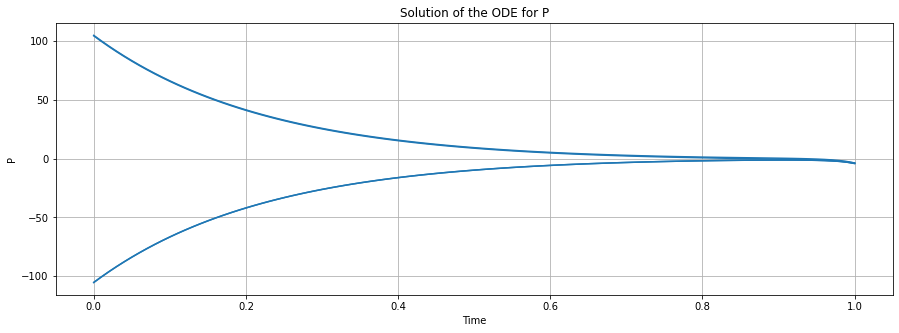

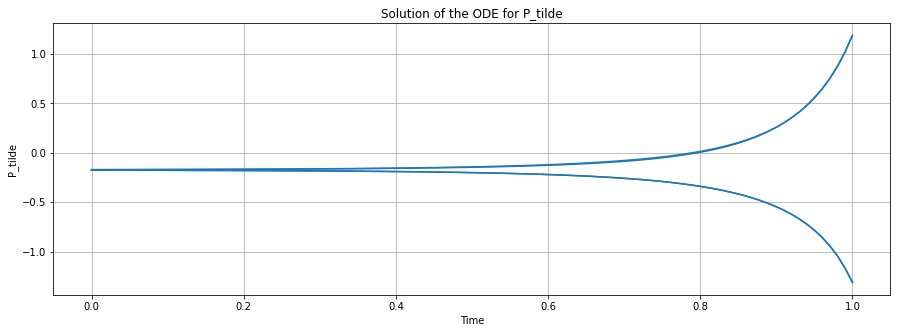

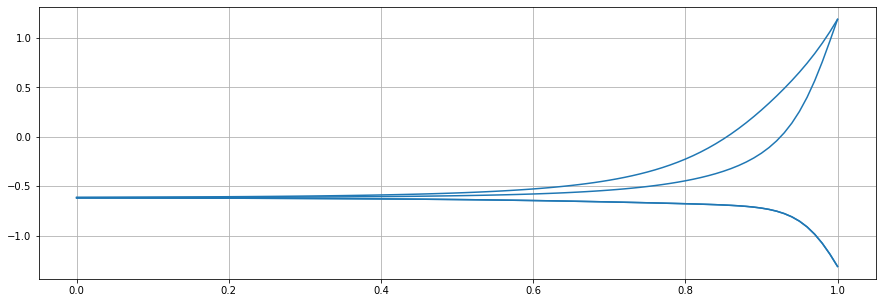

In [130]:
G = np.array([[3.8, 4.2], [4.2, 3.8]])
L = np.array([[8, 4], [4, 8]])
n = 100

ode_solver = ODE_Solver(t_final=1,
                        t_initial=0,
                        G=G,
                        L=L,
                        n=100)

t, y = ode_solver.solve_ODE('P')

y_inv = np.zeros_like(y)

for i in range(y.shape[0]):
    y_inv[i] = np.linalg.inv(y[i])

ode_solver.plot_ODE_solution("P")
ode_solver.plot_ODE_solution("P_tilde")
plt.figure(figsize=(15, 5))
plt.plot(t, np.reshape(y_inv, (ode_solver.n+1, 4)), color='C0')
plt.grid()
plt.show()